<center>

# Project 2

## Bhavya Patel

</center>

## About Dataset

I have found this dataset "2024 Unicorn and Emerging Unicorn Companies" from Kaggle. This dataset provides insights into private companies with high valuations, specifically unicorns (companies with valuations of 1 billion dollars or more) and emerging unicorns (companies valued between 500 million dollars and 1 billion dollars).
<br>
More Information about the dataset can be found https://www.kaggle.com/datasets/sashakorovkina/2024-unicorn-and-emerging-unicorn-companies/data.

In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

## Problem

Question: What factors help emerging unicorns evolve into unicorns? Are there observable trends in total Equity funding or regions that signal future unicorns? 

To solve this problem, I have first cleaned and wrangled the dataset. After that, I will do some exploratory data analysis. Then, I did a correlation analysis to check the relationships between key variables. Then, I built a logistic regression model aimed at predicting whether a company would become a unicorn or remain an emerging unicorn based on key features. To better understand the model's decision-making process, we analyzed the feature importance of our predictor variables using the coefficients from the logistic regression model.<br>

#### Let's look at some data from the 2 csv files.

Here's some Unicorn Companies and in the following table are Emerging Unicorn Companies.

In [319]:
uc[['company_name', 'country', 'region', 'lead_investors', 'post_money_value', 'total_eq_funding']].head()

,company_name,country,region,lead_investors,post_money_value,total_eq_funding
0,ByteDance,China,Asia,"Kohlberg Kravis Roberts Japan, Sequoia Capital",2.200000e+11,8.000000e+09
1,Ant Group,China,Asia,"GIC, Temasek Holdings",1.500000e+11,1.900000e+10
2,SpaceX,United States,North America,Mirae Asset Venture Investment,1.250000e+11,9.000000e+09
3,Reliance Retail,India,Asia,Abu Dhabi Investment Authority,1.000000e+11,8.000000e+09
4,OpenAI,United States,North America,Microsoft,8.000000e+10,1.100000e+10


In [320]:
euc[['company_name', 'country', 'region', 'lead_investors', 'post_money_value', 'total_eq_funding']].head()

,company_name,country,region,lead_investors,post_money_value,total_eq_funding
0,Nxtra Data,India,Asia,The Carlyle Group,986000000.0,237000000.0
1,Butternut Box,United Kingdom,Europe,General Atlantic,985000000.0,467000000.0
2,Bizongo,India,Asia,Schroder Adveq,980000000.0,290000000.0
3,Augment,United States,North America,Sutter Hill Ventures,977000000.0,252000000.0
4,OpenStore,United States,North America,Lux Capital,970000000.0,137000000.0


## Data Cleaning & Wrangling

From the post_money_value and total_eq_funding, let's remove the "$" dollar sign, "M" for Millions, and "B" for Billions. <br>
Let's Replace M with 10^6 and B with 10^9; for safe measures, also remove K and replace it with 10^3.

In [322]:
def clean_money_columns(df, column_name):
    df[column_name] = df[column_name].replace({'\$': '', 'K': 'e3', 'M': 'e6', 'B': 'e9', ',': ''}, regex=True).astype(float)
    return df

uc = clean_money_columns(uc, ['post_money_value', 'total_eq_funding'])
euc = clean_money_columns(euc, ['post_money_value', 'total_eq_funding'])

Let's remove unnecessary columns like company_link, img_src, and unnamed from the datasets. <br>
Replace any missing values with Unknown in columns like country, region, and lead_investors. <br>
Remove any records that have a post-money value below 500000000 from emerging unicorns and 1000000000 from unicorns. <br>

In [324]:
def clean_dataset(df, min_post_money_value):
    df = df.drop(columns=['Unnamed: 0', 'company_link', 'img_src'], errors='ignore')
    df = clean_money_columns(df, 'post_money_value')
    df = clean_money_columns(df, 'total_eq_funding')

    df['country'].fillna('Unknown', inplace=True)
    df['region'].fillna('Unknown', inplace=True)
    df['lead_investors'].fillna('Unknown', inplace=True)

    df = df[df['post_money_value'] >= min_post_money_value]

    df = df[df['total_eq_funding'] > 0]

    return df

uc = clean_dataset(uc, 1000000000)
euc = clean_dataset(euc, 500000000)

Let's combine the 2 datasets and give them a status as either unicorn or emerging unicorn.<br>

In [380]:
euc['status'] = 'Emerging Unicorn'
euc['status_encoded'] = 0
uc['status']  = 'Unicorn'
uc['status_encoded'] = 1
combined = pd.concat([uc, euc], ignore_index=True)

## Exploratory Data Analysis

#### Regional Growth Trends

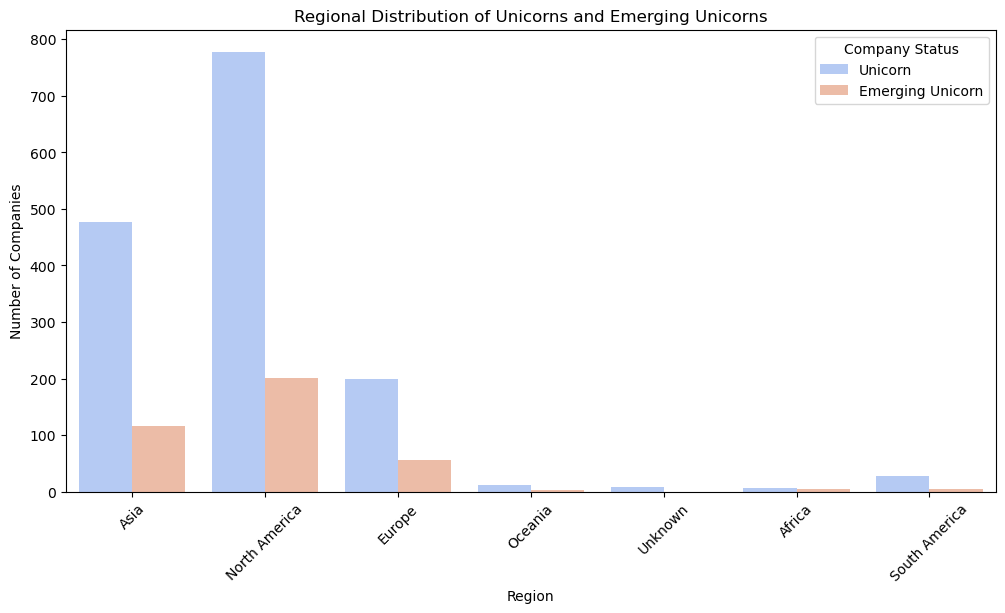

In [328]:
plt.figure(figsize=(12, 6))
sns.countplot(data=combined, x='region', hue='status', palette='coolwarm')
plt.title('Regional Distribution of Unicorns and Emerging Unicorns')
plt.xlabel('Region')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.legend(title='Company Status')
plt.show()

From the above graph, the highest number of unicorn and emerging unicorn companies are from North America. Followed by Asia and Europe.<br>

#### Industry and Region Interaction for Emerging Unicorns Companies

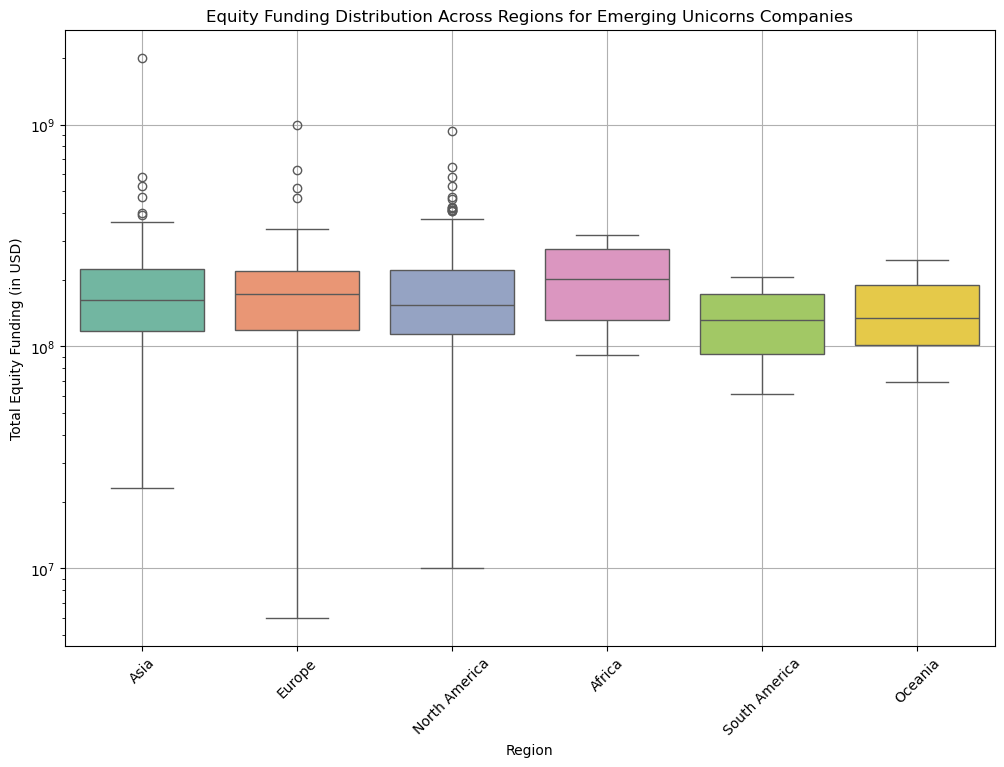

In [331]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=euc, x='region', y='total_eq_funding', palette='Set2')
plt.title('Equity Funding Distribution Across Regions for Emerging Unicorns Companies')
plt.xlabel('Region')
plt.ylabel('Total Equity Funding (in USD)')
plt.yscale('log') 
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The above box plot shows Africa's highest median equity funding. The median total equity funding is almost equal across all regions. However, from outliers, we can reduce the number of emerging unicorn companies from Asia, North America, and Europe that have received more funding than the range of equity funding in that region. <br> 

#### Industry and Region Interaction for Unicorns Companies

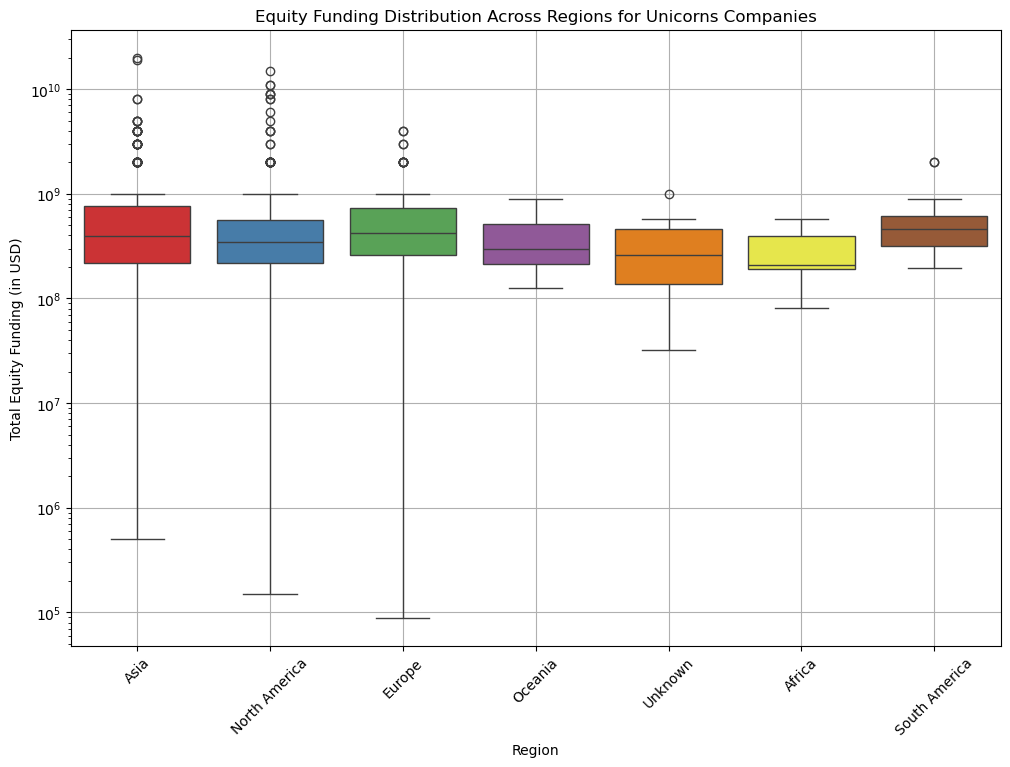

In [333]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=uc, x='region', y='total_eq_funding', palette='Set1')
plt.title('Equity Funding Distribution Across Regions for Unicorns Companies')
plt.xlabel('Region')
plt.ylabel('Total Equity Funding (in USD)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

From the above box plot, most unicorn companies from Asia and North America have received total equity funding of over 1 Billion USD. The range of equity funding is also massive in Asia, North America, and Europe. <br>

## Correlation Analysis

Correlation analysis is a statistical method used to evaluate the strength and direction of relationships between two or more variables. In this study, we explore how different factors (like total equity funding and region) relate to a company's post-money valuation, which could provide insights into what drives a company toward unicorn status.  <br>
We'll use LabelEncoder from sklearn.preprocessing to convert regions into numerical values. We'll use the Pandas inbuilt .corr() method to find the correlation, and the heatmap will be plotted using matplotlib. <br>


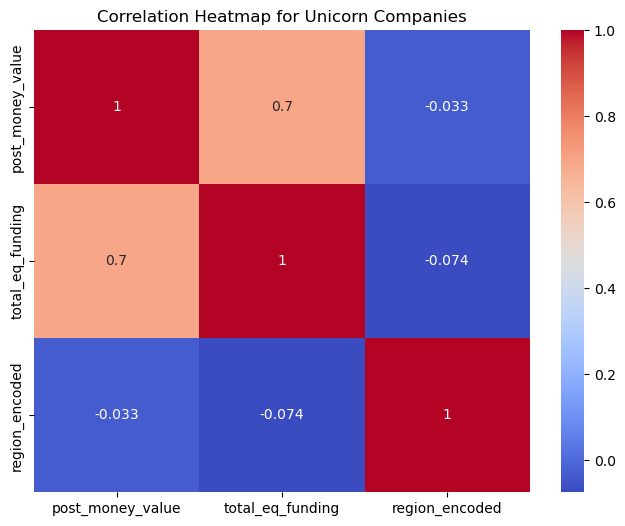




                  post_money_value  total_eq_funding  region_encoded
post_money_value          1.000000          0.696048       -0.032514
total_eq_funding          0.696048          1.000000       -0.074130
region_encoded           -0.032514         -0.074130        1.000000


In [401]:
label_encoder = LabelEncoder()
uc['region_encoded'] = label_encoder.fit_transform(uc['region'])
ucorr = uc[['post_money_value', 'total_eq_funding', 'region_encoded']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(ucorr, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap for Unicorn Companies')
plt.show()
print("\n\n")
print(ucorr)

<b>Post-Money Valuation & Total Equity Funding:</b> The correlation between these two variables is 0.7 approx, indicating a strong positive relationship. This suggests that companies with higher total funding tend to have higher valuations, which is expected, as more funding generally indicates greater growth potential and investor confidence. <br>

<b>Post-Money Valuation & Region:</b> The correlation is -0.033, which is very close to zero, meaning there is no significant relationship between a company's valuation and its geographical region. This indicates that for unicorn companies, region doesn't play a major role in determining their valuation. <br>

<b>Total Equity Funding & Region:</b> The correlation is -0.074, indicating a slight negative relationship, but it is negligible. The total funding does not appear to be strongly influenced by the company's region for unicorn companies.

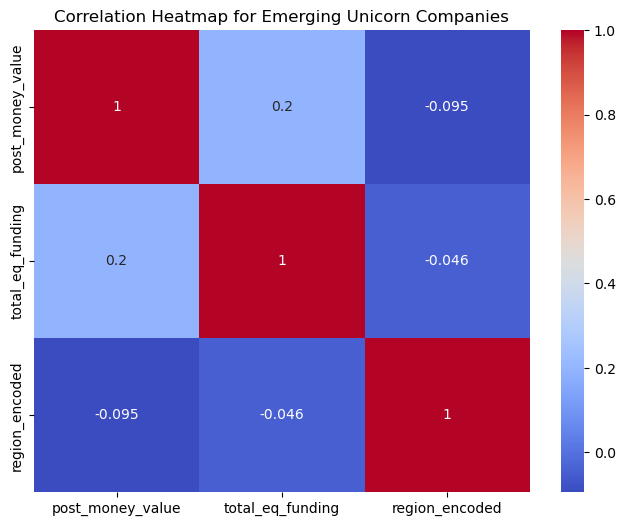




                  post_money_value  total_eq_funding  region_encoded
post_money_value          1.000000          0.196072       -0.094544
total_eq_funding          0.196072          1.000000       -0.045508
region_encoded           -0.094544         -0.045508        1.000000


In [338]:
euc['region_encoded'] = label_encoder.fit_transform(euc['region'])
ecorr = euc[['post_money_value', 'total_eq_funding', 'region_encoded']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(ecorr, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap for Emerging Unicorn Companies')
plt.show()
print("\n\n")
print(ecorr)

<b>Post-Money Valuation & Total Equity Funding:</b> The correlation here is 0.2 approx, which indicates a weak positive relationship. For emerging unicorns, total funding does not have as strong an influence on valuation as it does for unicorn companies. This suggests that other factors may play a larger role in determining the valuation of emerging unicorns, compared to fully developed unicorns. <br>

<b>Post-Money Valuation & Region:</b> The correlation is -0.095, which indicates a weak negative relationship. While weak, this suggests that for emerging unicorns, region could have a minor impact, with companies in certain regions potentially being valued less than in others. <br>

<b>Total Equity Funding & Region:</b> With a correlation of -0.046, there is virtually no relationship between a company's region and the amount of total equity funding it receives. This result is consistent with the findings for unicorn companies.

## Logistic Regression

### Building a Logistic Regression Model

Logistic regression is a statistical model that is often used for binary classification problems, which makes it a great choice for predicting the likelihood of a company transitioning from an emerging unicorn (status = 0) to a unicorn (status = 1). <br>
Logistic regression model can also provide insights into how each factor (e.g., total equity funding, region) contributes to the probability of a company reaching unicorn status. <br>
We're training the model on the features: total equity funding, region, and other relevant factors like post-money valuation. <br>

In [394]:
X = combined[['total_eq_funding', 'region_encoded', 'post_money_value']]
Y = combined['status_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")


Accuracy: 0.7904929577464789
AUC-ROC: 0.9865059609589939


<br>
Accuracy came out to be 79%. This means that the model correctly predicted whether a company is a unicorn or emerging unicorn 79% of the time on the test data.  <br>
The AUC-ROC score is 98%, which indicates that the model effectively distinguishes between unicorns and emerging unicorns. A high AUC (close to 1) suggests that the model makes strong predictions, even if the dataset is imbalanced or the problem is complex. <br>
The high AUC-ROC score shows that the model can rank companies by their likelihood of becoming unicorns. The model is performing well in predicting which emerging companies have the potential to reach unicorn status based on total equity funding, region, and post-money value. <br>

### Feature Importance

Feature Importance is a technique used to understand which features (variables) in a dataset are most influential in predicting the target variable in a machine learning model. 
By calculating the importance of each feature, we can see which variables most strongly affect the model's predictions. <br>

In [396]:
importance = log_model.coef_[0]
for i, v in enumerate(importance):
    print(f"Feature: {X.columns[i]}, Coefficient: {v}")

Feature: total_eq_funding, Coefficient: 4.968292928292049e-10
Feature: region_encoded, Coefficient: -6.174130402423293e-17
Feature: post_money_value, Coefficient: 1.2710048385989698e-09


<br>
<b>Total Equity Funding:</b> This positive coefficient, although very small, suggests that higher total equity funding increases the likelihood of a company becoming a unicorn. <br>
The magnitude of the coefficient is quite small because the features might not be scaled. Total equity funding is likely measured in large units (e.g., millions or billions), which could result in smaller coefficient values in logistic regression. Despite the small value, the positive sign indicates a positive relationship between funding and unicorn status. <br> <br>
<b>Region Encoded:</b> The coefficient for the region is almost zero, meaning that the model doesn't consider region to be a strong predictor of unicorn status. <br><br>
<b>Post_money_value:</b> This positive coefficient suggests that higher post-money value correlates with a higher probability of a company reaching unicorn status. The magnitude is also small, likely for similar reasons —scaling. <br><br>

## Conclusion

The analysis aimed to explore any key factors that help decide where an emerging unicorn will become a future unicorn.  <br>
<br>
The correlational analysis aimed to assess how key variables, post-money value, total equity funding, and region, are interrelated. And how they might signal a company's potential to evolve from an emerging unicorn to a unicorn.  <br>
For both emerging unicorns and unicorns, the correlation between total equity funding and post-money value was positive, with values of 0.7 for unicorns and 0.2 for emerging unicorns. This indicates that, in both cases, there is a positive relationship between the amount of funding a company has raised and its post-money valuation. However, the correlation is stronger for unicorns. This suggests that higher levels of funding are more indicative of unicorn status.<br>
On the other hand, the correlation between the region and the other two variables (post-money value and total equity funding) was close to zero in both datasets, implying that region alone may not be a strong predictor of a company's likelihood to become a unicorn.  <br>
<br>
The Logistic Regression Model deepened our understanding of predicting whether a company would become a unicorn or remain an emerging unicorn based on key features. The accuracy of 79% indicates that the model correctly predicted unicorn status nearly four out of five times.<br> 
However, the AUC-ROC score of 98.6% is particularly impressive. The AUC-ROC measures the model's ability to distinguish between classes (in this case, unicorns vs. emerging unicorns). This suggests that while accuracy might not fully reflect the model's performance, the logistic regression model can rank companies by their likelihood of achieving unicorn status. <br>
<br>
To better understand the model's decision-making process, we analyzed the feature importance of our predictor variables using the coefficients from the logistic regression model. Feature importance helps us identify which factors are the most significant drivers of the target outcome (unicorn status), offering insights into the underlying trends in the data. <br>
Total equity funding and post-money value were the most important predictors, both with positive coefficients, suggesting that higher funding and valuation levels significantly increase a company's likelihood of becoming a unicorn. However, the coefficient for the region was almost zero, which means it had little to no predictive power.<br>
<br>
Therefore, total equity funding and post-money value are the important factors that help determine if an emerging unicorn company will become a unicorn company. <br>
The region is not an important factor with no predictive power.

